In [78]:
!pip install metpy ######### Instalar o modulo do metpy, com rotinas meteorologicas
#### Primeiro passo, importar as bibliotecas que seraão ultilizadas
import pandas as pd  #### Leitura e processamento de dados no python, tipo o Excel do Python
import datetime as dt ########### Biblioteca com funcçoes que ajudam com datas
import numpy as np    ####### Biblioteca com funçoes Matematicas
from tqdm.notebook import trange ############ Cria barra de carregamento para poder acompanhar o processor
import matplotlib.pyplot as plt ########## Biblioteca com Funçoes para plotagem de graficos
from sklearn.preprocessing import MinMaxScaler ########## Funçoes para normalizar os dados de entrada da rede
############## TensorFlow 
from tensorflow.keras.layers import Dense,Input,Conv2D,Flatten,AveragePooling2D ########### Camadas que ultilizaremos na rede
from tensorflow.keras import Sequential ####### Tipo de modelo que usaremos
from tensorflow.keras.callbacks import ReduceLROnPlateau #### Função para Reduzir a taxa de aprendizado (LR)
import h5py
from sklearn.model_selection import train_test_split
from metpy.plots import SkewT
from metpy.units import pandas_dataframe_to_unit_arrays, units

In [2]:
######## Função de normalização Tanh, e desnormalização, para mais informação entre em :
## https://alfurka.github.io/2018-11-10-preprocessing-for-nn/ 
def tanh_norm(x,mean,std):
    return 0.5*np.tanh(0.01*((x-mean)/std))
def unorm_tanh(x,mean,std):
    return ((np.arctanh(x/0.5)/0.01)*std)+mean

In [54]:
h5file=h5py.File('Sondagem_Goes16.h5','r')
X=h5file['goes'][:]
y=h5file['sondagem'][:]
h5file.close()

In [55]:
### Normalizar os dados de entrada
scaler=MinMaxScaler((-1,1))
print(X.shape)
sh=X.shape
x=np.reshape(X,(sh[0]*sh[1]*sh[2],1))
x=scaler.fit_transform(x)
x=np.reshape(x,(sh[0],sh[1],sh[2],1))

(10032, 32, 32)


In [5]:
### nesse processo se inicia o processo de normalização da saida (Y) da rede, iremos ultilizar a 
##função tanh_norm, no caso o perfio de temperatura
means=[]
stds=[]
y_norm=[]
for level in range(11):
    means.append(np.mean(y[:,level,0]))
    stds.append(np.std(y[:,level,0]))
for i in range(len(y)):
    xii=[]
    for level in range(11):
        xii.append(tanh_norm(y[i,level,0],means[level],stds[level]))
    y_norm.append(xii)
y_norm=np.array(y_norm)

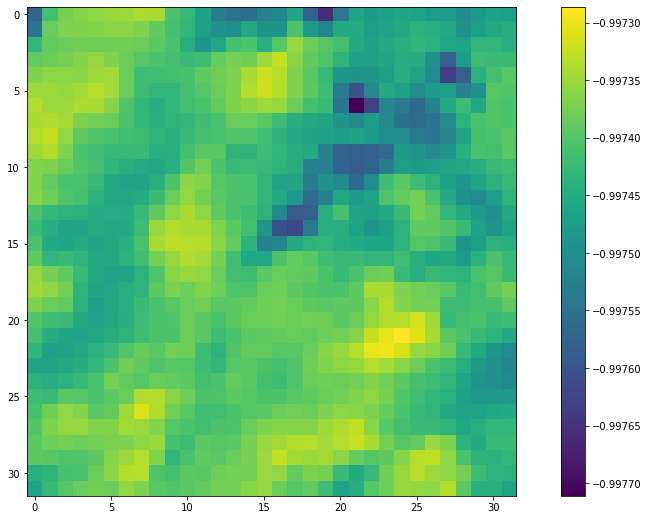

[[-99.9 -99.9]
 [  5.3  -3.1]
 [ -2.9  -3.4]
 [-14.4 -17.2]
 [-54.  -70. ]
 [-52.3 -71.4]
 [-51.3 -70.6]
 [-52.4 -72.7]
 [-55.9 -75.7]
 [-61.5 -79.1]
 [-63.6 -79.6]]
[-0.00771732 -0.00021663 -0.00152641 -0.00554028 -0.00832281 -0.00504302
 -0.0032368  -0.00120618 -0.00145016 -0.00027061  0.00017606]


In [12]:
fig=plt.figure(figsize=(16,9))
plt.imshow(x[0,:,:,0])
plt.colorbar()
plt.show()
print(y[0,:])
print(y_norm[0,:])

In [13]:
#### Dividir o conjunto de treinemento e validação
X_train, X_test, y_train, y_test = train_test_split(
    x, y_norm, test_size=0.15, random_state=875)

In [105]:
##### Modelo Tensorflow-Keras que ultilizaremos, é im modelo de apenas 1 camada pois não temos muitos dados
model=Sequential()
model.add(Input((32,32,1)))
model.add(Conv2D(32,3,activation='tanh'))
model.add(AveragePooling2D(2))
model.add(Conv2D(32,3,activation='tanh'))
model.add(AveragePooling2D(2))
model.add(Conv2D(32,3,activation='tanh'))
model.add(Conv2D(32,3,activation='tanh'))
model.add(Flatten())
model.add(Dense(32,activation='tanh'))
## nesta camada abaixo a saida da rede com a função de ativação linear f(x)=x
model.add(Dense(11,activation='linear'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 30, 30, 32)        320       
_________________________________________________________________
average_pooling2d_10 (Averag (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 13, 13, 32)        9248      
_________________________________________________________________
average_pooling2d_11 (Averag (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 4, 4, 32)          9248      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 2, 2, 32)          9248      
_________________________________________________________________
flatten_5 (Flatten)          (None, 128)              

In [106]:
## huber_loss logcosh mse são outras função de minização do erro
model.compile(loss='logcosh',optimizer='Adam') ## o optimizer= Adam

In [107]:
#### A função abaixo reduz a taxa de aprendizendo mais informaçoes :
### http://deeplearningbook.com.br/a-taxa-de-aprendizado-de-uma-rede-neural/
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=50, min_lr=0.00001,verbose=1)

In [108]:
### Aqui iremos treinar a rere com os dados ja processados 
history=model.fit(X_train,y_train,verbose=2,epochs=300,batch_size=16,
                  validation_data=(X_test,y_test),callbacks=[reduce_lr])

Train on 8527 samples, validate on 1505 samples
Epoch 1/300
8527/8527 - 3s - loss: 4.6494e-04 - val_loss: 1.3953e-05
Epoch 2/300
8527/8527 - 3s - loss: 1.5969e-05 - val_loss: 1.3189e-05
Epoch 3/300
8527/8527 - 3s - loss: 1.5392e-05 - val_loss: 1.3594e-05
Epoch 4/300
8527/8527 - 3s - loss: 1.4924e-05 - val_loss: 1.2819e-05
Epoch 5/300
8527/8527 - 3s - loss: 1.3893e-05 - val_loss: 1.3289e-05
Epoch 6/300
8527/8527 - 3s - loss: 1.3734e-05 - val_loss: 1.4134e-05
Epoch 7/300
8527/8527 - 3s - loss: 1.3383e-05 - val_loss: 1.3789e-05
Epoch 8/300
8527/8527 - 3s - loss: 1.3383e-05 - val_loss: 1.2330e-05
Epoch 9/300
8527/8527 - 3s - loss: 1.3253e-05 - val_loss: 1.3007e-05
Epoch 10/300
8527/8527 - 3s - loss: 1.3138e-05 - val_loss: 1.3034e-05
Epoch 11/300
8527/8527 - 3s - loss: 1.3447e-05 - val_loss: 1.3233e-05
Epoch 12/300
8527/8527 - 3s - loss: 1.3199e-05 - val_loss: 1.3461e-05
Epoch 13/300
8527/8527 - 3s - loss: 1.3201e-05 - val_loss: 1.3872e-05
Epoch 14/300
8527/8527 - 3s - loss: 1.3145e-05 - va

Epoch 115/300
8527/8527 - 3s - loss: 1.2103e-05 - val_loss: 1.1888e-05
Epoch 116/300
8527/8527 - 3s - loss: 1.2106e-05 - val_loss: 1.1873e-05
Epoch 117/300
8527/8527 - 3s - loss: 1.2114e-05 - val_loss: 1.1866e-05
Epoch 118/300
8527/8527 - 3s - loss: 1.2102e-05 - val_loss: 1.1927e-05
Epoch 119/300
8527/8527 - 3s - loss: 1.2105e-05 - val_loss: 1.1873e-05
Epoch 120/300
8527/8527 - 3s - loss: 1.2107e-05 - val_loss: 1.1863e-05
Epoch 121/300
8527/8527 - 3s - loss: 1.2105e-05 - val_loss: 1.1937e-05
Epoch 122/300
8527/8527 - 3s - loss: 1.2101e-05 - val_loss: 1.1874e-05
Epoch 123/300
8527/8527 - 3s - loss: 1.2100e-05 - val_loss: 1.1928e-05
Epoch 124/300
8527/8527 - 3s - loss: 1.2103e-05 - val_loss: 1.1886e-05
Epoch 125/300
8527/8527 - 3s - loss: 1.2108e-05 - val_loss: 1.1864e-05
Epoch 126/300
8527/8527 - 3s - loss: 1.2101e-05 - val_loss: 1.1868e-05
Epoch 127/300
8527/8527 - 3s - loss: 1.2091e-05 - val_loss: 1.1886e-05
Epoch 128/300
8527/8527 - 3s - loss: 1.2108e-05 - val_loss: 1.1875e-05
Epoch 

Epoch 229/300
8527/8527 - 3s - loss: 1.2079e-05 - val_loss: 1.1858e-05
Epoch 230/300
8527/8527 - 3s - loss: 1.2078e-05 - val_loss: 1.1858e-05
Epoch 231/300
8527/8527 - 3s - loss: 1.2078e-05 - val_loss: 1.1859e-05
Epoch 232/300
8527/8527 - 3s - loss: 1.2076e-05 - val_loss: 1.1859e-05
Epoch 233/300
8527/8527 - 3s - loss: 1.2078e-05 - val_loss: 1.1864e-05
Epoch 234/300
8527/8527 - 3s - loss: 1.2078e-05 - val_loss: 1.1861e-05
Epoch 235/300
8527/8527 - 3s - loss: 1.2078e-05 - val_loss: 1.1858e-05
Epoch 236/300
8527/8527 - 3s - loss: 1.2078e-05 - val_loss: 1.1858e-05
Epoch 237/300
8527/8527 - 3s - loss: 1.2079e-05 - val_loss: 1.1859e-05
Epoch 238/300
8527/8527 - 3s - loss: 1.2077e-05 - val_loss: 1.1866e-05
Epoch 239/300
8527/8527 - 3s - loss: 1.2078e-05 - val_loss: 1.1860e-05
Epoch 240/300
8527/8527 - 3s - loss: 1.2078e-05 - val_loss: 1.1863e-05
Epoch 241/300
8527/8527 - 3s - loss: 1.2078e-05 - val_loss: 1.1860e-05
Epoch 242/300
8527/8527 - 3s - loss: 1.2078e-05 - val_loss: 1.1862e-05
Epoch 

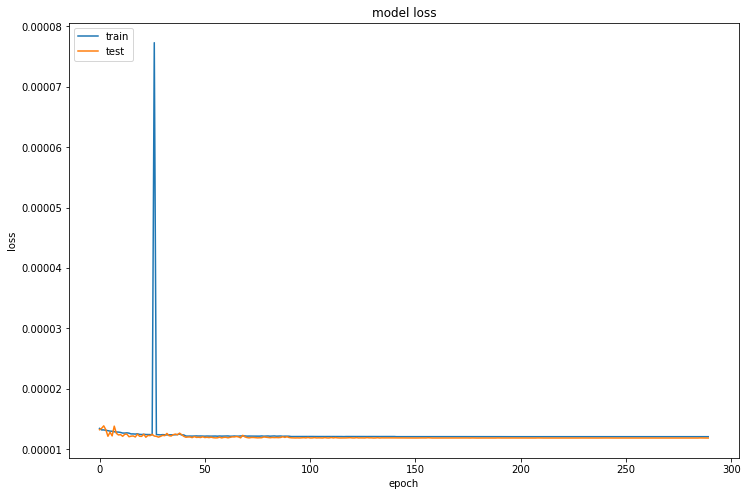

In [109]:
#### Plot do erro variando ao longo do treinamento 
fig=plt.figure(figsize=(12,8))
# summarize history for loss
plt.plot(history.history['loss'][10:])
plt.plot(history.history['val_loss'][10:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [110]:
pred=model.predict(X_test)

In [111]:
pred[0]

array([-6.9123176e-05,  1.2256327e-04,  1.3215035e-04,  1.8498352e-04,
        4.7590569e-04,  3.1612534e-04,  1.8374482e-04,  5.0806571e-05,
       -1.1845292e-05, -2.0136489e-04, -2.4474162e-04], dtype=float32)

In [112]:
#### Iremos fazer nesse bloco a previsão do conjunto de dados teste ,ou seja a rede funcionadno no dia dia 
### e logo em seguida desnormlizaremos os dados 
pred_unorm=[]
for i in range(len(pred)):
    xii=[]
    for level in range(11):
        xii.append(unorm_tanh(pred[i,level]/10.,means[level],stds[level]))
    pred_unorm.append(xii)
pred_unorm=np.array(pred_unorm)

In [127]:
### Escolha um exemplo do conjunto de treinamento
exemplo=150
p_levels=[1000,925,850,700,500,400,300,250,200,150,100]
temp_model=np.ma.masked_where(pred_unorm[exemplo]<=-75.,pred_unorm[exemplo])
temp_obs=np.ma.masked_where(y[exemplo,:,0]==-99.9,y[exemplo,:,0])

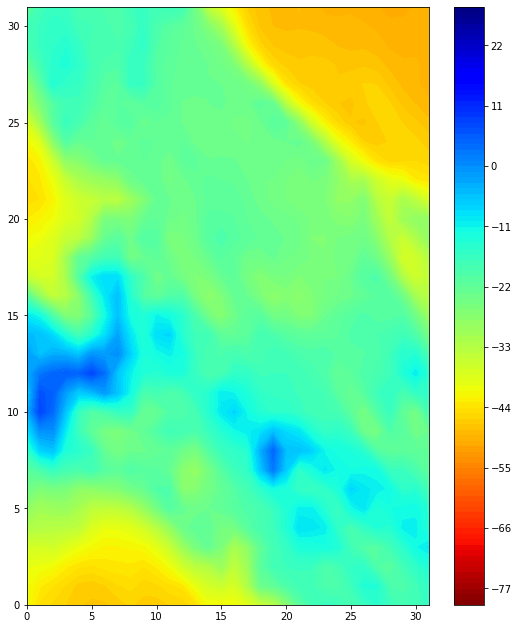

In [128]:
fig = plt.figure(figsize=(9, 11))
clev=np.arange(-80,30)
plt.contourf(X[exemplo,:,:]-273.15,clev,cmap='jet_r')
plt.colorbar()
plt.show()

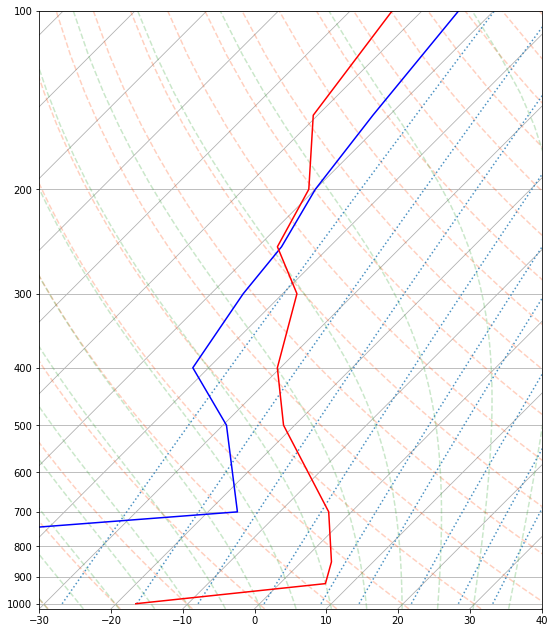

In [129]:
fig = plt.figure(figsize=(9, 11))
# Initiate the skew-T plot type from MetPy class loaded earlier
skew = SkewT(fig, rotation=45)
skew.ax.set_xlim(-30, 40)
skew.ax.set_ylim(1020, 100)
### 
skew.plot(p_levels, temp_obs.data, 'b',)
skew.plot(p_levels, temp_model.data, 'r',)

####
# Adicionado Adiabatica seca e umida
skew.plot_dry_adiabats(t0=np.arange(233, 533, 10) * units.K,
                       alpha=0.25, color='orangered')
skew.plot_moist_adiabats(t0=np.arange(233, 400, 5) * units.K,
                         alpha=0.25, color='tab:green')
skew.plot_mixing_lines(p=np.arange(1000, 99, -20) * units.hPa,
                       linestyle='dotted', color='tab:blue')